In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import h5py
from tqdm.notebook import tqdm
import datetime
import random
import seaborn
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, plot_precision_recall_curve
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, SGDClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pickle

In [3]:
data = np.load('./Data/input_final.npy', allow_pickle=True)
labels = np.load('./Data/labels_final.npy', allow_pickle=True)

cols = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'type',
    'id',
    'uri',
    'track_href',
    'analysis_url',
    'duration_ms',
    'time_signature',
    'year',
    'artist',
    'song',
    'followers',
    'artist_popularity',
    'index'
]

float_cols = []
df_all = pd.DataFrame(data, columns=cols)
df_features = pd.DataFrame()
df_labels = pd.DataFrame(labels)
for col in cols:
    try:
        df_all[col] = df_all[col].astype(float)
        df_features[col] = df_all[col]
        float_cols.append(col)
    except:
        pass

df_features = df_features.astype(np.float64)
data_df = df_features
features_withlabels = df_features.copy()
features_withlabels['labels'] = labels
df_hits = features_withlabels[(features_withlabels['labels'] == 1)]
features_withlabels


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,followers,artist_popularity,index,labels
0,0.537,0.674,5.0,-5.134,0.0,0.0277,0.0088,0.000000,0.2650,0.330,136.002,214107.0,4.0,2006.0,2930717.0,72.0,0.0,1
1,0.563,0.592,9.0,-4.571,1.0,0.0276,0.2090,0.000051,0.1320,0.136,104.016,267933.0,4.0,2006.0,2367624.0,71.0,1.0,1
2,0.835,0.741,8.0,-1.609,1.0,0.0339,0.0172,0.057700,0.0826,0.612,111.963,182066.0,4.0,2006.0,418932.0,64.0,2.0,1
3,0.449,0.691,4.0,-5.650,0.0,0.0349,0.4770,0.000000,0.0966,0.201,93.267,380200.0,4.0,2006.0,358455.0,59.0,3.0,1
4,0.888,0.577,1.0,-7.702,0.0,0.0612,0.0986,0.000000,0.1310,0.609,84.003,241840.0,4.0,2006.0,584202.0,65.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9753,0.782,0.685,9.0,-3.935,0.0,0.0383,0.7110,0.000000,0.2040,0.793,116.630,221500.0,4.0,2020.0,28211.0,34.0,9791.0,0
9754,0.439,0.714,10.0,-5.845,1.0,0.0373,0.6870,0.000008,0.4870,0.526,120.381,226679.0,4.0,2020.0,2715.0,37.0,9792.0,0
9755,0.705,0.762,0.0,-6.745,1.0,0.0316,0.6560,0.000002,0.2060,0.883,104.984,199053.0,4.0,2020.0,40.0,0.0,9793.0,0
9756,0.872,0.749,0.0,-9.042,1.0,0.0987,0.0219,0.000000,0.1100,0.912,143.940,173333.0,4.0,2020.0,62.0,0.0,9794.0,0


# Preprocessing #

Skewness for features before applying power transform:
followers            3.943956
duration_ms          3.532373
speechiness          3.488162
liveness             2.118769
instrumentalness     1.810756
acousticness         1.138973
tempo                0.247288
key                  0.000630
index               -0.001662
year                -0.002660
valence             -0.012818
artist_popularity   -0.109493
danceability        -0.393834
energy              -0.645744
mode                -0.734626
loudness            -1.729611
time_signature      -4.244516
dtype: float64
Skewness for features after applying power transform:
instrumentalness     1.331490
time_signature       0.962888
speechiness          0.668164
acousticness         0.399459
liveness             0.338173
duration_ms          0.120918
tempo                0.043624
loudness             0.036557
year                -0.001295
danceability        -0.040844
valence             -0.046801
followers           -0.078119
energy

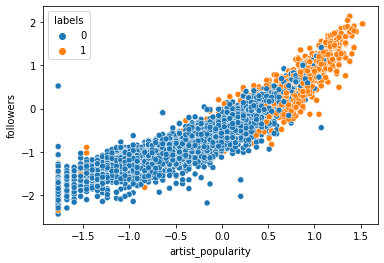

Index(['danceability', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'year', 'artist_popularity', 'index'],
      dtype='object')
       danceability          key     loudness         mode  speechiness  \
count   9176.000000  9176.000000  9176.000000  9176.000000  9176.000000   
mean       0.038266     0.003688     0.026710     0.002628    -0.018671   
std        0.979351     0.998754     0.931483     0.999085     0.992055   
min       -2.536411    -1.640236    -2.580947    -1.432563    -1.429398   
25%       -0.635300    -0.850379    -0.599631    -1.432563    -0.845170   
50%        0.042373     0.042104     0.099014     0.698050    -0.330329   
75%        0.735383     0.790132     0.678418     0.698050     0.661377   
max        2.588283     1.457495     2.594717     0.698050     2.006283   

       acousticness  instrumentalness     liveness      valence        tempo  \
cou

In [4]:
df_missing = data_df.isna().any()

print('Skewness for features before applying power transform:')
print(df_features.skew().sort_values(ascending=False))

sample_features = ['duration_ms', 'loudness']
# Plotting skewness
for feature in sample_features:
    seaborn.displot(df_features[feature])
    plt.title(f'Distribution plot for {feature} - BEFORE')
    plt.savefig(f'./EDA/plots/skew/{feature}_before.png', facecolor='w', bbox_inches='tight')
    plt.close()

df_features_mtransforms = df_features.copy()

df_nparr = np.array(df_features)
df_nptrans = power_transform(df_features, method='yeo-johnson', standardize=True)

float_cols_myr = float_cols.copy()
df_trans = pd.DataFrame(df_nptrans, columns=float_cols_myr)
df_features = df_trans

print('Skewness for features after applying power transform:')
print(df_features.skew().sort_values(ascending=False))
df_features_copy = df_features.copy()
df_features_copy['labels'] = features_withlabels['labels']
seaborn.pairplot(df_features_copy[['loudness', 'energy', 'acousticness', 'followers', 'artist_popularity', 'labels']].iloc[np.random.permutation(df_features_copy.shape[0])[:]], hue='labels')
plt.title('Pair-plots')
plt.savefig(f'./EDA/plots/correlation/pair_plots.png', facecolor='w', bbox_inches='tight')
plt.close()

# Dropping columns
df_features.drop(['energy', 'followers'], axis=1, inplace=True)
float_cols.remove('energy')
float_cols.remove('followers')

indices_all = np.array([True]*df_features.shape[0])
for col in float_cols:
    indices_col = ((df_features[col] <= 2.6) & (df_features[col] >= -2.6))
    print(f'feature = {col}', end='    ')
    print((indices_col == False).sum())
    indices_all = np.logical_and(indices_all, indices_col)


# Plotting skewness
for feature in sample_features:
    seaborn.displot(df_features[feature])
    plt.title(f'Distribution plot for {feature} - AFTER')
    plt.savefig(f'./EDA/plots/skew/{feature}_after.png', facecolor='w', bbox_inches='tight')
    plt.close()

df_features = df_features.loc[indices_all]
df_features_mtransforms = df_features_mtransforms.loc[indices_all]
labels = labels[indices_all]

print(f'Hits = {(labels == 1).sum()}')
print(f'Non-hits = {(labels == 0).sum()}')
print(f'Total = {df_features.shape}')


seaborn.scatterplot(x=df_features_copy['artist_popularity'], y=df_features_copy['followers'], data=df_features_copy, hue='labels')
plt.show()
print(df_features.columns)
print(df_features.describe())
np.random.seed(0)

arr = dict(df_features.iloc[0])

print(arr)

# EDA #

In [5]:
plt.figure(figsize=(14, 8))
df_corr = features_withlabels.corr()
seaborn.heatmap(df_corr, xticklabels=df_corr.columns.values, yticklabels=df_corr.columns.values, annot=True, cmap='Blues')
plt.savefig(f'./EDA/plots/correlation/correlation_heatmap.png', facecolor='w', bbox_inches='tight')
plt.close()

In [6]:
def plot_tsne(df_features, labels, plot_title, count):
    np.random.seed(0)
    indices = np.random.permutation(df_features.shape[0])[:count]
    tsne_input = np.array(df_features)[indices]
    tsne_labels = labels.squeeze()[indices]
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(tsne_input)
    seaborn.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=tsne_labels)
    plt.title(plot_title)
    plt.savefig(f'./EDA/plots/dimensionality_reduction/tsne/{plot_title}.png', facecolor='w', bbox_inches='tight')
    plt.close()

plot_tsne(df_features_mtransforms, labels, 'tsne_before_transforms', 3000)
plot_tsne(df_features, labels, 'tsne_after_transforms', 3000)

In [7]:
def plot_pca(df_features, labels, plot_title, count=None):
    df = df_features.copy()
    if count == None:
        count = df.shape[0]
    df['label'] = labels.squeeze()
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(np.array(df_features))

    df['pca-one'] = pca_result[:, 0]
    df['pca-two'] = pca_result[:, 1]
    df['pca-three'] = pca_result[:, 2]

    print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

    np.random.seed(0)
    indices = np.random.permutation(df.shape[0])[:count]

    df_cur = df.iloc[indices]
    seaborn.scatterplot(data=df_cur, x='pca-one', y='pca-two', hue='label')
    plt.savefig(f'./EDA/plots/dimensionality_reduction/pca/{plot_title}_2d.png', facecolor='w', bbox_inches='tight')
    plt.close()


    np.random.seed(0)
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.view_init(20, 90)
    ax.scatter(
        xs=df_cur['pca-one'], 
        ys=df_cur['pca-two'], 
        zs=df_cur['pca-three'], 
        c=df_cur["label"], 
        cmap='coolwarm',
    )
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.savefig(f'./EDA/plots/dimensionality_reduction/pca/{plot_title}_3d.png', facecolor='w', bbox_inches='tight')
    plt.close()



plot_pca(df_features_mtransforms, labels, 'pca_before_transforms')
plot_pca(df_features, labels, 'pca_after_transforms')

Explained variation per principal component: [9.99951671e-01 4.82596976e-05 6.94324596e-08]


C:\Users\SAMYAK~1\AppData\Local\Temp/ipykernel_29932/3995758498.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


Explained variation per principal component: [0.15228753 0.14040575 0.10277833]


C:\Users\SAMYAK~1\AppData\Local\Temp/ipykernel_29932/3995758498.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


# Models #

Logistic Regression

# Train-Test Splitting #

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(df_features), labels.squeeze(), test_size = 0.3, random_state=0, stratify=labels.squeeze())
print(X_train.shape)
print(X_test.shape)

(6423, 15)
(2753, 15)


In [9]:
def calc_scores(Y_test, prediction, model_name, plot=False):
    matrix = confusion_matrix(Y_test, prediction.round().astype(int))
    tn, fp, fn, tp = matrix.ravel()
    scores = {}
    scores['accuracy'] = (tn + tp) / (tn + tp + fn + fp)
    scores['precision'] = (tp) / (tp + fp)
    scores['recall'] = (tp) / (tp + fn)
    scores['f1_score'] = (2 * scores['precision'] * scores['recall']) / (scores['precision'] + scores['recall'])
    scores['specificity'] = (tn) / (tn + fp)

    if plot:
        seaborn.heatmap(matrix / np.sum(matrix), fmt='.2%', cmap='Blues', annot=True)
        plt.xlabel('Predicted value')
        plt.ylabel('Actual value')
        plt.title('Confusion matrix')
        plt.savefig(f'./models/{model_name}/plots/confusion_matrix_{model_name}.png', facecolor='w', bbox_inches='tight')
        plt.close()
    return scores

def calc_curves(Y_test, prediction_proba, model_name, plot=False):
    ra_score = roc_auc_score(Y_test, prediction_proba)
    fpr, tpr, thresholds_roc = roc_curve(Y_test, prediction_proba)
    if plot:
        plt.plot(fpr, tpr)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.savefig(f'./models/{model_name}/plots/roc_curve_{model_name}.png', facecolor='w', bbox_inches='tight')
        plt.close()
    print(f'RA score = {ra_score}')
    print(f'best threshold : {thresholds_roc[np.argmax(tpr - fpr)]}')

def perform_grid_search(model, model_name, parameters, X_train, Y_train, X_test, Y_test, scoring):
    clf = GridSearchCV(model, parameters, scoring=scoring, cv=5)
    clf.fit(X_train, Y_train)

    prediction_proba = clf.predict_proba(X_test)[:, 1]
    prediction_labels = prediction_proba.round().astype(int)

    print(f'Grid search number of 1s = {(prediction_labels == 1).sum()}')
    print(f'Grid search number of 0s = {(prediction_labels == 0).sum()}')

    print('Scores for best model')
    scores2 = calc_scores(Y_test, prediction_labels, model_name, plot=True)
    calc_curves(Y_test, prediction_proba, model_name, plot=True)
    print(clf.best_params_)
    print(clf.best_score_)
    print(scores2)

    return clf.best_estimator_



In [9]:
def logistic_regression(X_train, Y_train, max_iters=1000):
    clf = LogisticRegression(random_state=0, max_iter=max_iters, penalty='l2')
    clf.fit(X_train, Y_train)
    return clf

clf = logistic_regression(X_train, Y_train, max_iters=1000)
clf.predict(X_test)
model_coeffs = clf.coef_
print(f'Model coefficients = {model_coeffs}')
prediction_proba_lr = clf.predict_proba(X_test)[:, 1]
prediction_labels_lr = prediction_proba_lr.round().astype(int)

scores = calc_scores(Y_test, prediction_labels_lr, 'logistic_regression', plot=False)
calc_curves(Y_test, prediction_proba_lr, 'logistic_regression', plot=False)
print(f'Score for logistic regression = \n{scores}')

print("\n---------------------------\n")

grid_search_model = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
grid_params = {'C': np.arange(0.1, 2, 0.1)}
print(grid_params)
best_model = perform_grid_search(grid_search_model, 'logistic_regression', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/logistic_regression/logistic_regression.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')


Model coefficients = [[ 0.64239476  0.02449479  0.85149421  0.19002975  0.05120556 -0.27869129
  -1.19034008 -0.19831717 -0.6720481   0.07663718 -0.23103486  0.11928567
   6.28874511  2.89431308 -6.54442736]]
RA score = 0.9720435843483587
best threshold : 0.5412621476999704
Score for logistic regression = 
{'accuracy': 0.9295314202687976, 'precision': 0.8885106382978724, 'recall': 0.943089430894309, 'f1_score': 0.9149868536371604, 'specificity': 0.9204131227217497}

---------------------------

{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])}
Grid search number of 1s = 1176
Grid search number of 0s = 1577
Scores for best model
RA score = 0.972171457235026
best threshold : 0.5381446455174896
{'C': 1.4000000000000001}
0.9673614913465591
{'accuracy': 0.928441699963676, 'precision': 0.8869047619047619, 'recall': 0.9421860885275519, 'f1_score': 0.9137100306614104, 'specificity': 0.9191980558930741}
Best model found using Gr

In [10]:
def decision_tree(X_train, Y_train, criterion='gini', max_depth=10):
    clf = DecisionTreeClassifier(criterion=criterion, random_state=0, max_depth=max_depth)
    clf.fit(X_train, Y_train)
    return clf

clf = decision_tree(X_train, Y_train)
clf.fit(X_train, Y_train)

prediction_labels_dt = clf.predict(X_test)
prediction_proba_dt = clf.predict_proba(X_test)[:, 1]
scores = calc_scores(Y_test, prediction_labels_dt, 'decision_tree', plot=False)
calc_curves(Y_test, prediction_proba_dt, 'decision_tree', plot=False)
print(prediction_proba_dt)
print(f'Score = {scores}')

grid_search_model = DecisionTreeClassifier(random_state=0)
grid_params = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1, 20).astype(int)}
best_model = perform_grid_search(grid_search_model, 'decision_tree', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/decision_tree/decision_tree.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')

# tree_rules = export_text(clf, feature_names=float_cols)
# print(tree_rules)
# prediction = clf.predict(X_test)


RA score = 0.9258425067037223
best threshold : 0.75
[1.         0.00476948 0.00476948 ... 0.00476948 0.99073461 0.00297619]
Score = {'accuracy': 0.9240828187431892, 'precision': 0.8973451327433628, 'recall': 0.9159891598915989, 'f1_score': 0.9065713008493518, 'specificity': 0.9295261239368166}
Grid search number of 1s = 1141
Grid search number of 0s = 1612
Scores for best model
RA score = 0.9661290517319916
best threshold : 0.35714285714285715
{'criterion': 'entropy', 'max_depth': 5}
0.9407996755656948
{'accuracy': 0.9222666182346531, 'precision': 0.8913234005258545, 'recall': 0.9186991869918699, 'f1_score': 0.9048042704626336, 'specificity': 0.9246658566221142}
Best model found using Grid search = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)


RA score = 0.9800334445223755
best threshold : 0.45583799136506925
[2.78566574e-01 1.21127443e-02 7.49395689e-04 ... 3.45309552e-02
 9.78920300e-01 1.64727369e-01]
Score = {'accuracy': 0.9360697420995278, 'precision': 0.9205058717253839, 'recall': 0.9205058717253839, 'f1_score': 0.9205058717253839, 'specificity': 0.9465370595382746}
Grid search number of 1s = 1085
Grid search number of 0s = 1668
Scores for best model
RA score = 0.9788189265043723
best threshold : 0.3963094540609263
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 30}
0.9737552801349286
{'accuracy': 0.9353432618961133, 'precision': 0.928110599078341, 'recall': 0.9096657633242999, 'f1_score': 0.9187956204379562, 'specificity': 0.9526123936816525}
Best model found using Grid search = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=30, oob_score=True, random_state=0)


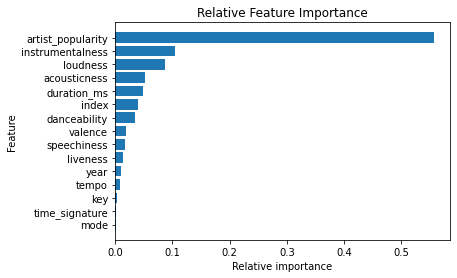

In [11]:
def random_forest(X_train, Y_train, criterion='gini', max_depth=10, n_estimators=10):
    clf = RandomForestClassifier(criterion=criterion, max_depth=max_depth, n_estimators=n_estimators, bootstrap=True, max_features='sqrt', oob_score=True, random_state=0)
    clf.fit(X_train, Y_train)
    return clf

clf = random_forest(X_train, Y_train, n_estimators=25)
clf.fit(X_train, Y_train)

prediction_labels_rf = clf.predict(X_test)
prediction_proba_rf = clf.predict_proba(X_test)[:, 1]
scores = calc_scores(Y_test, prediction_labels_rf, 'random_forest', plot=False)
calc_curves(Y_test, prediction_proba_rf, 'random_forest', plot=False)
print(prediction_proba_rf)
print(f'Score = {scores}')

grid_search_model = RandomForestClassifier(bootstrap=True, max_features='sqrt', oob_score=True, random_state=0)
grid_params = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(1, 10).astype(int), 'n_estimators': np.arange(25, 31).astype(int)}
best_model = perform_grid_search(grid_search_model, 'random_forest', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/random_forest/random_forest.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')

feature_list = list(df_features.columns)
f_imp_val = (best_model.feature_importances_).tolist()

feature_importances = {}
val = 0
for f_idx in range(len(feature_list)):
    feature_importances[feature_list[f_idx]] = f_imp_val[f_idx]
    val += f_imp_val[f_idx]

sorted_tuples = (sorted(feature_importances.items(), key=lambda item: item[1]))
sorted_tuples.reverse()
feature_imp_list = [val[0] for val in sorted_tuples][::-1]
feature_val_list = [val[1] for val in sorted_tuples][::-1]

plt.barh(feature_imp_list, feature_val_list)
plt.ylabel('Feature')
plt.xlabel('Relative importance')
plt.title('Relative Feature Importance')
plt.savefig('./models/random_forest/plots/feature_importance_random_forest.png', facecolor='w', bbox_inches='tight')


In [12]:
def gaussian_NB(X_train, Y_train):
    clf = GaussianNB()
    clf.fit(X_train, Y_train)
    return clf

clf = gaussian_NB(X_train, Y_train)
clf.fit(X_train, Y_train)

prediction_labels_rf = clf.predict(X_test)
prediction_proba_rf = clf.predict_proba(X_test)[:, 1]
scores = calc_scores(Y_test, prediction_labels_rf, 'gaussian_NB', plot=True)
calc_curves(Y_test, prediction_proba_rf, 'gaussian_NB', plot=True)

file = open(f'./models/gaussian_NB/gaussian_NB.pickle', 'wb')
pickle.dump(clf, file)
file.close()

print(prediction_proba_rf)
print(f'Score = {scores}')

RA score = 0.9446656151454184
best threshold : 0.9517791804367347
[9.43206733e-01 3.02775203e-04 2.45210619e-07 ... 7.14861688e-01
 9.99110632e-01 9.74995992e-01]
Score = {'accuracy': 0.8412640755539411, 'precision': 0.7410071942446043, 'recall': 0.9304426377597109, 'f1_score': 0.8249899879855827, 'specificity': 0.7812879708383961}


In [13]:
# import warnings
# warnings.filterwarnings("ignore")
# t_X_train, t_X_test, t_Y_train, t_Y_test = train_test_split(df_features, labels.squeeze(), test_size=0.3, random_state=0, stratify=labels.squeeze())
def sgd_classifier(X_train, Y_train, learning_rate, alpha, max_iters=1000):
    clf = SGDClassifier(random_state=0, max_iter=max_iters, penalty='l2', loss='log', eta0=learning_rate, learning_rate='constant', alpha=alpha)
    clf.fit(X_train, Y_train)
    return clf

clf = sgd_classifier(X_train, Y_train, 0.01, 0.1)
clf.predict(X_test)
model_coeffs = clf.coef_
print(f'Model coefficients = {model_coeffs}')
prediction_proba_sgd = clf.predict_proba(X_test)[:, 1]
prediction_labels_sgd = prediction_proba_sgd.round().astype(int)

scores = calc_scores(Y_test, prediction_labels_sgd, 'sgd_classifier', plot=False)
calc_curves(Y_test, prediction_proba_sgd, 'sgd_classifier', plot=False)
print(f'Score for logistic regression = \n{scores}')

grid_search_model = SGDClassifier(random_state=0, max_iter=1000, loss='log', learning_rate='constant')
grid_params = {'penalty': ['l1', 'l2'], 'eta0': np.arange(0.01, 0.1, 0.01), 'alpha': np.arange(0.1, 1, 0.1)}
print(grid_params)
best_model = perform_grid_search(grid_search_model, 'sgd_classifier', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/sgd_classifier/sgd_classifier.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')

Model coefficients = [[ 0.21711444  0.03011958  0.42933997  0.01318021  0.03330517 -0.19700724
  -0.48336742 -0.09845064 -0.18729193  0.04462645 -0.07630398  0.05115665
   0.05528181  1.06626994 -0.08479329]]
RA score = 0.9618933309624713
best threshold : 0.4900491447186431
Score for logistic regression = 
{'accuracy': 0.9106429349800218, 'precision': 0.8590492076730609, 'recall': 0.9304426377597109, 'f1_score': 0.8933217692974849, 'specificity': 0.8973268529769137}
{'penalty': ['l1', 'l2'], 'eta0': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]), 'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}
Grid search number of 1s = 1199
Grid search number of 0s = 1554
Scores for best model
RA score = 0.9618933309624713
best threshold : 0.4900491447186431
{'alpha': 0.1, 'eta0': 0.01, 'penalty': 'l2'}
0.9486366161789928
{'accuracy': 0.9106429349800218, 'precision': 0.8590492076730609, 'recall': 0.9304426377597109, 'f1_score': 0.8933217692974849, 'specificity': 0.8973268

In [14]:
def adaboost(X_train, Y_train, base_estimator=DecisionTreeClassifier(), learning_rate=0.05, n_estimators=10):
    clf = AdaBoostClassifier(base_estimator=base_estimator, learning_rate=learning_rate,n_estimators=n_estimators)
    clf.fit(X_train, Y_train)
    return clf

clf = adaboost(X_train, Y_train, n_estimators=40)
clf.fit(X_train, Y_train)
prediction_labels_ab = clf.predict(X_test)
prediction_proba_ab = clf.predict_proba(X_test)[:, 1]
scores = calc_scores(Y_test, prediction_labels_ab, 'adaboost', plot=False)
calc_curves(Y_test, prediction_proba_ab, 'adaboost', plot=False)
print(prediction_proba_ab)
print(f'Score = {scores}')
print("----- PERFORMING GRID SEARCH ------")
grid_search_model = AdaBoostClassifier()
grid_params = {'base_estimator': [DecisionTreeClassifier()] , 'learning_rate': np.arange(0.1, 1, 0.1) ,'n_estimators': np.arange(25, 31).astype(int)}
best_model = perform_grid_search(grid_search_model, 'adaboost', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/adaboost/adaboost.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')

RA score = 0.9105147734344899
best threshold : 0.9999999999999998
[1.00000000e+00 2.22044605e-16 2.22044605e-16 ... 2.22044605e-16
 1.00000000e+00 2.22044605e-16]
Score = {'accuracy': 0.9120958953868508, 'precision': 0.881729920564872, 'recall': 0.9024390243902439, 'f1_score': 0.8919642857142858, 'specificity': 0.9185905224787363}
----- PERFORMING GRID SEARCH ------
Grid search number of 1s = 1129
Grid search number of 0s = 1624
Scores for best model
RA score = 0.9117298402631656
best threshold : 0.9999999999999998
{'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.4, 'n_estimators': 25}
0.8352930687805653
{'accuracy': 0.9135488557936796, 'precision': 0.8848538529672276, 'recall': 0.9024390243902439, 'f1_score': 0.8935599284436495, 'specificity': 0.9210206561360875}
Best model found using Grid search = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.4,
                   n_estimators=25)


In [16]:
def mlp_classifier(X_train, Y_train, hidden_layer_size, activation,learning_rate_init, alpha, max_iter=1000, batch_size=256):
    clf = MLPClassifier(hidden_layer_sizes = hidden_layer_size, random_state=0, activation=activation, solver='sgd', learning_rate='constant', learning_rate_init=learning_rate_init, alpha=alpha, max_iter=max_iter, batch_size=batch_size)
    clf.fit(X_train, Y_train)
    return clf
clf = mlp_classifier(X_train, Y_train, (100,), 'logistic', 0.01, 0.1)
clf.predict(X_test)
# modelcoeffs = clf.coefs
# print(f'Model coefficients = {model_coeffs}')
prediction_proba_mlp = clf.predict_proba(X_test)[:, 1]
prediction_labels_mlp = prediction_proba_mlp.round().astype(int)

scores = calc_scores(Y_test, prediction_labels_mlp, 'mlp_classifier', plot=False)
calc_curves(Y_test, prediction_proba_mlp, 'mlp_classifier', plot=False)
print(f'Score for MLP classifier = \n{scores}')

grid_search_model = MLPClassifier(random_state=0, max_iter=1000, solver='sgd', learning_rate='constant')
grid_params = {'activation': ['relu'], 'learning_rate_init': np.arange(0.01, 0.1, 0.02), 'alpha': np.arange(0.1, 1, 0.2)}
print(grid_params)
best_model = perform_grid_search(grid_search_model, 'mlp_classifier', grid_params, X_train, Y_train, X_test, Y_test, 'average_precision')
file = open(f'./models/mlp_classifier/mlp_classifier.pickle', 'wb')
pickle.dump(best_model, file)
file.close()
print(f'Best model found using Grid search = {best_model}')


RA score = 0.977550899445811
best threshold : 0.38214670446700644
Score for MLP classifier = 
{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.926829268292683, 'f1_score': 0.9197669206633797, 'specificity': 0.9404617253948967}
{'activation': ['relu'], 'learning_rate_init': array([0.01, 0.03, 0.05, 0.07, 0.09]), 'alpha': array([0.1, 0.3, 0.5, 0.7, 0.9])}
Grid search number of 1s = 1132
Grid search number of 0s = 1621
Scores for best model
RA score = 0.9954898738942837
best threshold : 0.533538566338213
{'activation': 'relu', 'alpha': 0.1, 'learning_rate_init': 0.08999999999999998}
0.9935656324112276
{'accuracy': 0.9720305121685434, 'precision': 0.9549469964664311, 'recall': 0.976513098464318, 'f1_score': 0.9656096471639125, 'specificity': 0.9690157958687727}
Best model found using Grid search = MLPClassifier(alpha=0.1, learning_rate_init=0.08999999999999998, max_iter=1000,
              random_state=0, solver='sgd')


In [ ]:
from sklearn.svm import SVR
import os
def supportVectorRegression(X_train, Y_train, kernel='rbf'):
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, Y_train)
    return clf

kernels = ["linear", "poly", "rbf", "sigmoid", "precomputed"]

for kernel in kernels:
    # try:
    #     os.makedirs(f'./models/SVM/SVM_{kernel}/plots')
    # except:
    #     print(f'Folder already made')
    clf = supportVectorRegression(X_train, Y_train, kernel)
    clf.fit(X_train, Y_train)
    prediction_labels_rf = clf.predict(X_test)
    prediction_proba_rf = clf.predict_proba(X_test)[:, 1]
    scores = calc_scores(Y_test, prediction_labels_rf,f'SVM_{kernel}', plot=True)
    print(scores)
    calc_curves(Y_test, prediction_proba_rf,f'SVM_{kernel}', plot=True)
    file = open(f'./models/SVM_{kernel}/SVM_{kernel}.pickle', 'wb')
    pickle.dump(clf, file)
    file.close()

{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.926829268292683, 'f1_score': 0.9197669206633797, 'specificity': 0.9404617253948967}
RA score = 0.977550899445811
best threshold : 0.38214670446700644
{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.926829268292683, 'f1_score': 0.9197669206633797, 'specificity': 0.9404617253948967}
RA score = 0.977550899445811
best threshold : 0.38214670446700644
{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.926829268292683, 'f1_score': 0.9197669206633797, 'specificity': 0.9404617253948967}
RA score = 0.977550899445811
best threshold : 0.38214670446700644
{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.926829268292683, 'f1_score': 0.9197669206633797, 'specificity': 0.9404617253948967}
RA score = 0.977550899445811
best threshold : 0.38214670446700644
{'accuracy': 0.9349800217944061, 'precision': 0.9128113879003559, 'recall': 0.9268292682

In [10]:
pca_dim = TSNE(n_components=2, random_state=0)
dim_red_data = pca_dim.fit_transform(X_train)
temp_df = pd.DataFrame(dim_red_data, columns=['pca-one', 'pca-two'])

print(dim_red_data.shape)
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_label = kmeans.fit_predict(dim_red_data)
temp_df['clust'] = cluster_label
temp_df['res'] = Y_train

file = open(f'./models/clustering/clustering.pickle', 'wb')
pickle.dump(kmeans, file)
file.close()

seaborn.scatterplot(data=temp_df, x='pca-one', y='pca-two', hue='clust')
plt.savefig('./models/clustering/plots/clustering.png', facecolor='w', bbox_inches='tight')
plt.close()

C:\Users\Samyak Jain\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Samyak Jain\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(6423, 2)
